In [1]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

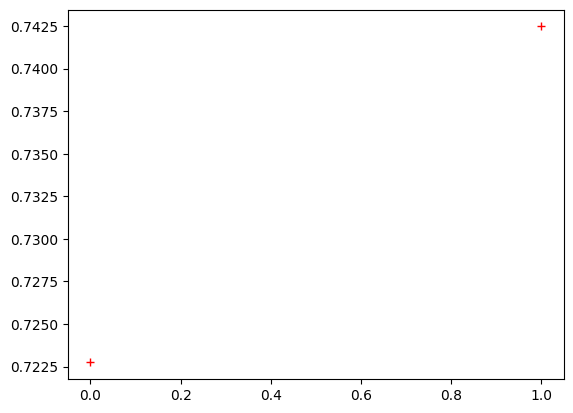

In [4]:
plt.plot([0.7227405241, 0.7424753279], 'r+')
plt.plot

/tmp/ipykernel_550557/2616823414.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lx, ly = center[num1], height[num1]
/tmp/ipykernel_550557/2616823414.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rx, ry = center[num2], height[num2]


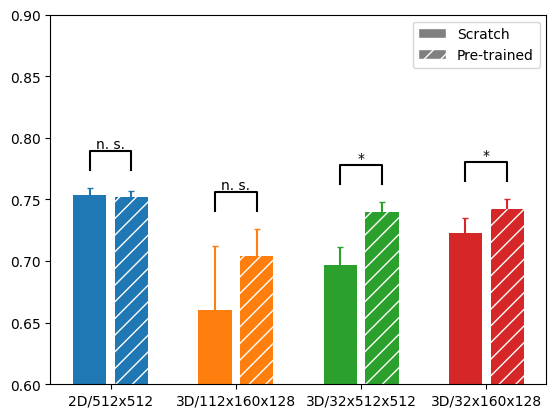

In [229]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scipy.stats
import pandas as pd
import numpy as np

fig, ax = plt.subplots()

def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

data = pd.read_csv('nnunet_results.csv', index_col=0)

average_dice_score = data.mean()
std_dice_score = data.std(axis=0)
# bars = np.arange(len(average_dice_score))
bars = [0, 1, 3, 4, 6, 7, 9, 10]
mids = [(bars[i] + bars[i + 1]) / 2 for i in range(0, len(bars), 2)]

cmap = mpl.colormaps['tab20']

err_kwargs = {'zorder':0}  #for matplotlib >= v1.4 use 'fmt':'none' instead

plt.rcParams['hatch.color'] = 'white'

legends = []
for i in range(0, len(bars), 2):
    ax.bar(bars[i], average_dice_score.iloc[i], align='center', color=cmap(i), label=data.columns[i])
    a = mpatches.Patch(color=cmap(i), label=data.columns[i])
    legends.append(a)

    ax.bar(bars[i + 1], average_dice_score.iloc[i + 1], align='center', color=cmap(i), hatch='//')
    ax.errorbar(bars[i], average_dice_score.iloc[i], yerr=std_dice_score.iloc[i], capsize=2.5, color=cmap(i), **err_kwargs)
    ax.errorbar(bars[i + 1], average_dice_score.iloc[i + 1], yerr=std_dice_score.iloc[i + 1], capsize=2.5, color=cmap(i), **err_kwargs)

scratch_patch = mpatches.Patch(facecolor='grey', edgecolor='white', label='Scratch')
pretrained_patch = mpatches.Patch(hatch='//', facecolor='grey', edgecolor='white', label='Pre-trained')
scratch_pretrain_legend = ax.legend(handles=[scratch_patch, pretrained_patch], loc='upper right')
# ax.add_artist(scratch_pretrain_legend)
# ax.legend(handles=legends, bbox_to_anchor=(1.37, 0.85))
# ax.add_artist(plot_main_legend)

# plt.legend(handles=[scratch_patch, pretrained_patch], bbox_to_anchor=[1.37, 2])
plt.ylim(0.6, 0.9)
for i in np.arange(0, len(average_dice_score), 2):
    _, pval = scipy.stats.ttest_ind(data.iloc[:, i], data.iloc[:, i + 1], alternative='less')
    barplot_annotate_brackets(i, i + 1, pval, bars, average_dice_score + std_dice_score)

plt.xticks(mids, data.columns[::2])
plt.show()

[0.5, 3.5, 6.5, 9.5]